<a href="https://colab.research.google.com/github/bipulsimkhada/Image-Segmentation-UNET/blob/main/ImageSegmentation_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import random
import warnings #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf



In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = '/content/drive/MyDrive/Colab Notebooks/U_NET/train/'
TEST_PATH = '/content/drive/MyDrive/Colab Notebooks/U_NET/validation/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

#### Collect file names for training and test date

In [ ]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH)) [1]
len(train_ids), len(test_ids)

(670, 65)

#### Creating image masks of dimension 128 x 128 (black images)

In [ ]:
print('Getting and resizing training images...')
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total = len(train_ids)):
  path = TRAIN_PATH + id_
  img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode ='constant', preserve_range=True)
  X_train[n] = img
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH,1), dtype=np.bool)

  #Masking all image to one single mask
  for mask_file in next(os.walk(path + '/masks/')) [2]:
    mask_ = imread(path + '/masks/' + mask_file)
    mask_ = np.expand_dims(resize(mask_,(IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)

  Y_train[n]=mask

# Resiing test Images

X_test = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
sizes_test =[]
print('Getting and resizing test images...')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total = len(test_ids)): 
  path = TEST_PATH + id_
  img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode ='constant', preserve_range=True)
  X_test[n] = img

print('Done!')


Getting and resizing training images...


<ipython-input-28-50221a878bcd>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  0%|          | 0/670 [00:00<?, ?it/s]<ipython-input-28-50221a878bcd>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH,1), dtype=np.bool)
100%|███████

Getting and resizing test images...



100%|██████████| 65/65 [00:01<00:00, 33.60it/s]

Done!


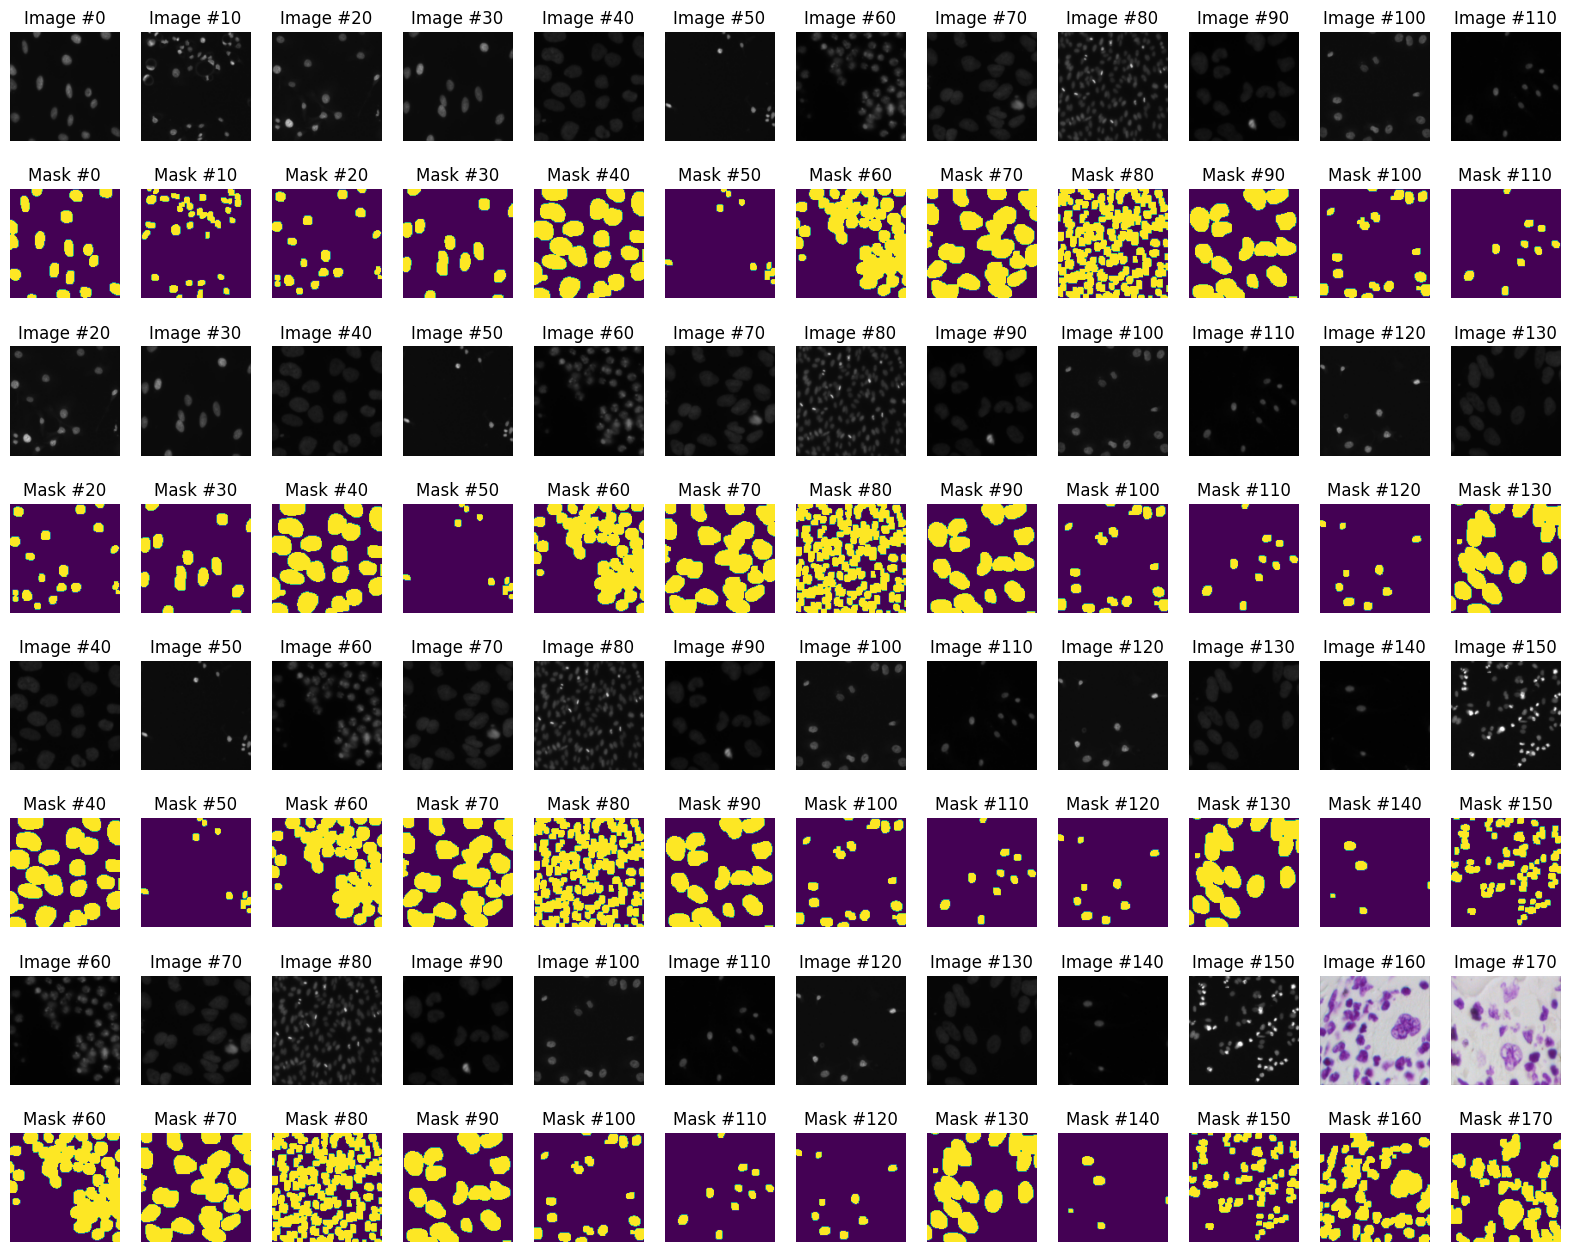

In [ ]:
# Illustrate the train images and masks
plt.figure(figsize=(20,16))
x,y = 12,4
for i in range(y):
  for j in range(x):
    plt.subplot(y*2,x,i*2*x+j+1)
    pos = i*20+j*10
    plt.imshow(X_train[pos])
    plt.title('Image #{}'.format(pos))
    plt.axis('off')
    plt.subplot(y*2,x,(i*2+1)*x+j+1)

    plt.imshow(np.squeeze(Y_train[pos]))
    plt.title('Mask #{}'.format(pos))
    plt.axis('off')

plt.show()


### Define a custom Metric called Intersection over Union (IoU)

In [ ]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
  labels = label(y_true_in >0.5)
  y_pred = label(y_pred_in >0.5)

  true_objects = len(np.unique(labels))
  pred_objects = len(np.unique(y_pred))

  intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins =(true_objects, pred_objects))[0]

  #Finding union between all objects
  area_true = np.histogram(labels, bins = true_objects)[0]
  area_pred = np.histogram(y_pred, bins = pred_objects)[0]
  area_true = np.expand_dims(area_true, -1)
  area_pred = np.expand_dims(area_pred, 0)

  #Union area
  union = area_true + area_pred - intersection

  #excluding background from the analysis
  intersection = intersection[1:,1:]
  union = union[1:,1:]
  union[union==0] = 1e-9

  #Computing intersection over union
  iou = intersection/union

  #Precision helper function
  def precision_at(threshold, iou):
    matches = iou>threshold
    true_positives = np.sum(matches, axis=1)
    false_positives = np.sum(matches, axis=0)
    false_negatives = np.sum(matches, axis=1)
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    return tp, fp, fn

  #loop over IoU thresholds
  prec=[]
  if print_table:
    print("Thresh\tTP\tFP\tFN\tPrec.")
  for t in np.arange(0.5,1.0,0.05):
    tp, fp, fn = precision_at(t,iou)
    if(tp+fp+fn)>0:
      p = tp/(tp+fp+fn)
    else:
      p=0
    
    if print_table:
      print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t,tp,fp,fn,p))
    prec.append(p)

  if print_table:
    print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
  return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
  batch_size = y_true_in.shape[0]
  metric =[]
  for batch in range(batch_size):
    value = iou_metric(y_true_in[batch], y_pred_in[batch])
    metric.append(value)
  return np.array(np.mean(metric), dtype = np.float32)

def my_iou_metric(label, pred):
  metric_value= tf.py_function(iou_metric_batch, [label,pred], tf.float32)
  return metric_value


### Building our U-Net Model

In [ ]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s= Lambda(lambda x:x/255)(inputs)

c1 = Conv2D(16,(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16,(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2,2)) (c1)

c2 = Conv2D(32,(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32,(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2,2)) (c2)

c3 = Conv2D(64,(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.1)(c3)
c3 = Conv2D(64,(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2,2)) (c3)

c4 = Conv2D(128,(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.1)(c4)
c4 = Conv2D(128,(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D((2,2)) (c4)

c5 = Conv2D(256,(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.1)(c5)
c5 = Conv2D(256,(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)

u6 = Conv2DTranspose(128,(2,2), strides=(2,2), padding='same')(c5)
u6 = concatenate([u6,c4])
c6 = Conv2D(128,(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
c6 =Dropout(0.1)(c6)
c6 = Conv2D(128,(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(64,(2,2), strides=(2,2), padding='same')(c6)
u7 = concatenate([u7,c3])
c7 = Conv2D(64,(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
c7 =Dropout(0.1)(c7)
c7 = Conv2D(64,(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

u8 = Conv2DTranspose(32,(2,2), strides=(2,2), padding='same')(c7)
u8 = concatenate([u8,c2])
c8 = Conv2D(32,(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
c8 =Dropout(0.1)(c8)
c8 = Conv2D(32,(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

u9 = Conv2DTranspose(16,(2,2), strides=(2,2), padding='same')(c8)
u9 = concatenate([u9,c1])
c9 = Conv2D(16,(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
c9 =Dropout(0.1)(c9)
c9 = Conv2D(16,(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1,(1,1), activation='sigmoid')(c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[my_iou_metric])
model.summary()



Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_5 (Lambda)              (None, 128, 128, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv2d_95 (Conv2D)             (None, 128, 128, 16  448         ['lambda_5[0][0]']               
                                )                                                                 
                                                                                            

In [ ]:
X_train.dtype
Y_train.dtype

dtype('bool')

### Fit our model

In [ ]:
# Initialize our callbacks
model_path ="/nuclei_finder_unet_1.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1
                             )

earlystop = EarlyStopping(monitor ='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)
# Fit our model 
results= model.fit(X_train, Y_train, validation_split=0.1,
                   batch_size=16, epochs = 10,
                   callbacks=[earlystop, checkpoint])

Epoch 1/10
38/38 [==============================] - ETA: 0s - loss: 0.3938 - my_iou_metric: 0.1173
Epoch 1: val_loss improved from inf to 0.21985, saving model to /nuclei_finder_unet_1.h5
38/38 [==============================] - 138s 4s/step - loss: 0.3938 - my_iou_metric: 0.1173 - val_loss: 0.2199 - val_my_iou_metric: 0.2244
Epoch 2/10
38/38 [==============================] - ETA: 0s - loss: 0.1902 - my_iou_metric: 0.2403
Epoch 2: val_loss did not improve from 0.21985
38/38 [==============================] - 133s 3s/step - loss: 0.1902 - my_iou_metric: 0.2403 - val_loss: 0.2329 - val_my_iou_metric: 0.2526
Epoch 3/10
38/38 [==============================] - ETA: 0s - loss: 0.1486 - my_iou_metric: 0.2698
Epoch 3: val_loss improved from 0.21985 to 0.15461, saving model to /nuclei_finder_unet_1.h5
38/38 [==============================] - 135s 4s/step - loss: 0.1486 - my_iou_metric: 0.2698 - val_loss: 0.1546 - val_my_iou_metric: 0.2715
Epoch 4/10
38/38 [==============================] - ET

### Generating our predictions for training and validation data

In [ ]:


# the first 90% was used for training
preds_train=model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)



19/19 [==============================] - 32s 2s/step


In [ ]:
# the last 10% used as validation
preds_val=model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

3/3 [==============================] - 3s 800ms/step


In [ ]:
# Threshold predictions
preds_train_t= (preds_train >0.5).astype(np.uint8)
preds_val_t=(preds_val>0.5).astype(np.uint8)

### Showing our predicted masks on our training data

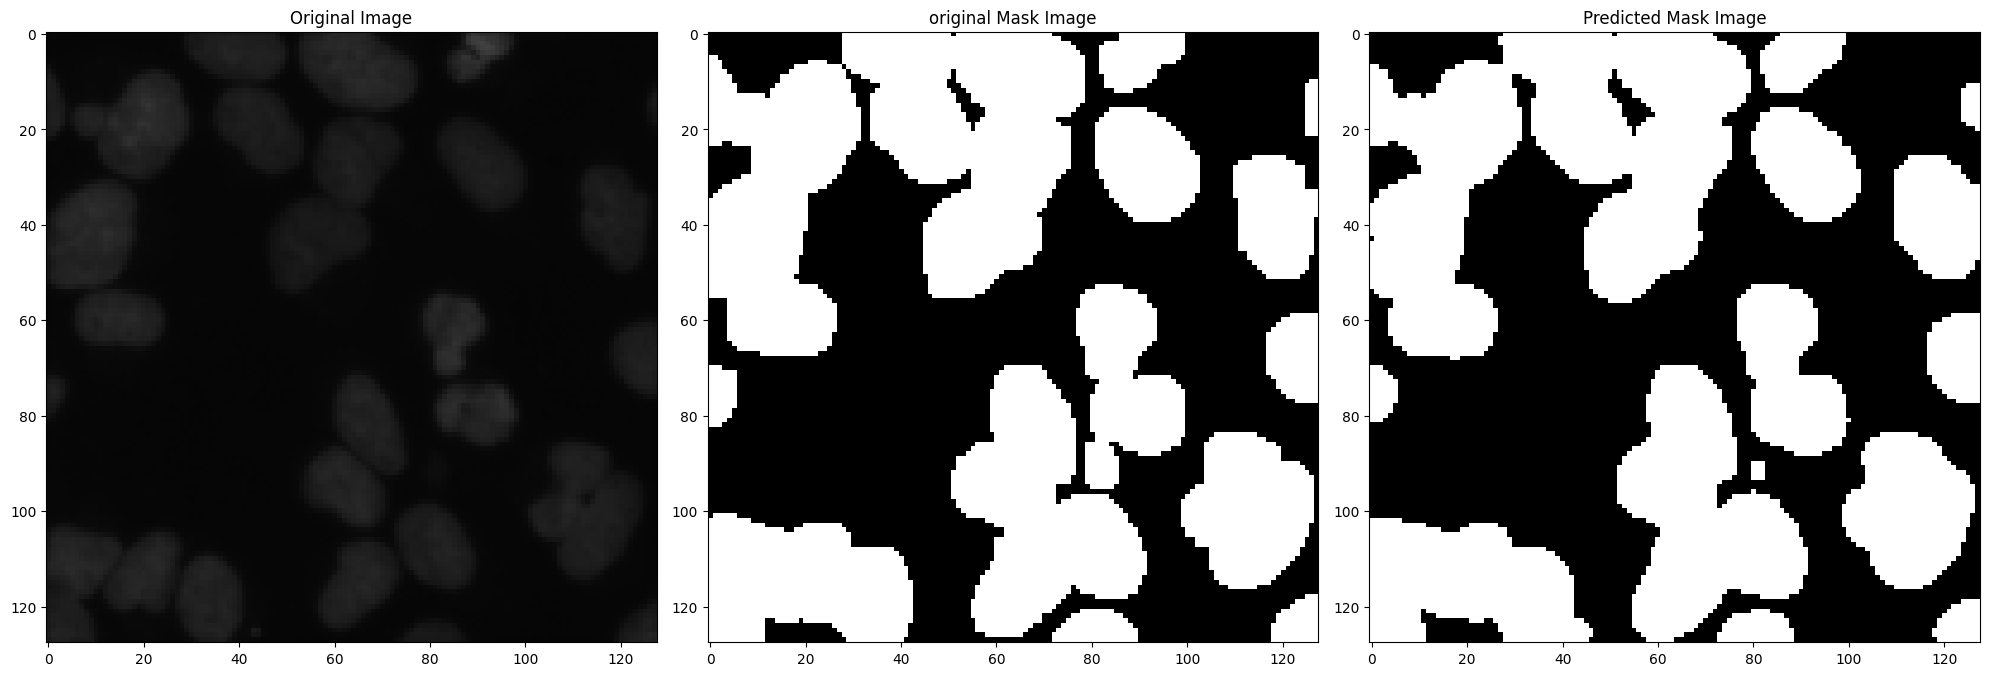

In [ ]:
# Ploting our predicted masks
ix = random.randint(0,602)
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(131)
imshow(X_train[ix])
plt.title("Original Image")

# Our original combined mask  
plt.subplot(132)
imshow(np.squeeze(Y_train[ix]))
plt.title("original Mask Image")
# The mask our U-Net model predicts
plt.subplot(133)
imshow(np.squeeze(preds_train_t[ix]>0.5))
plt.title("Predicted Mask Image")
plt.show()

### Showing our predicted masks on our validation data

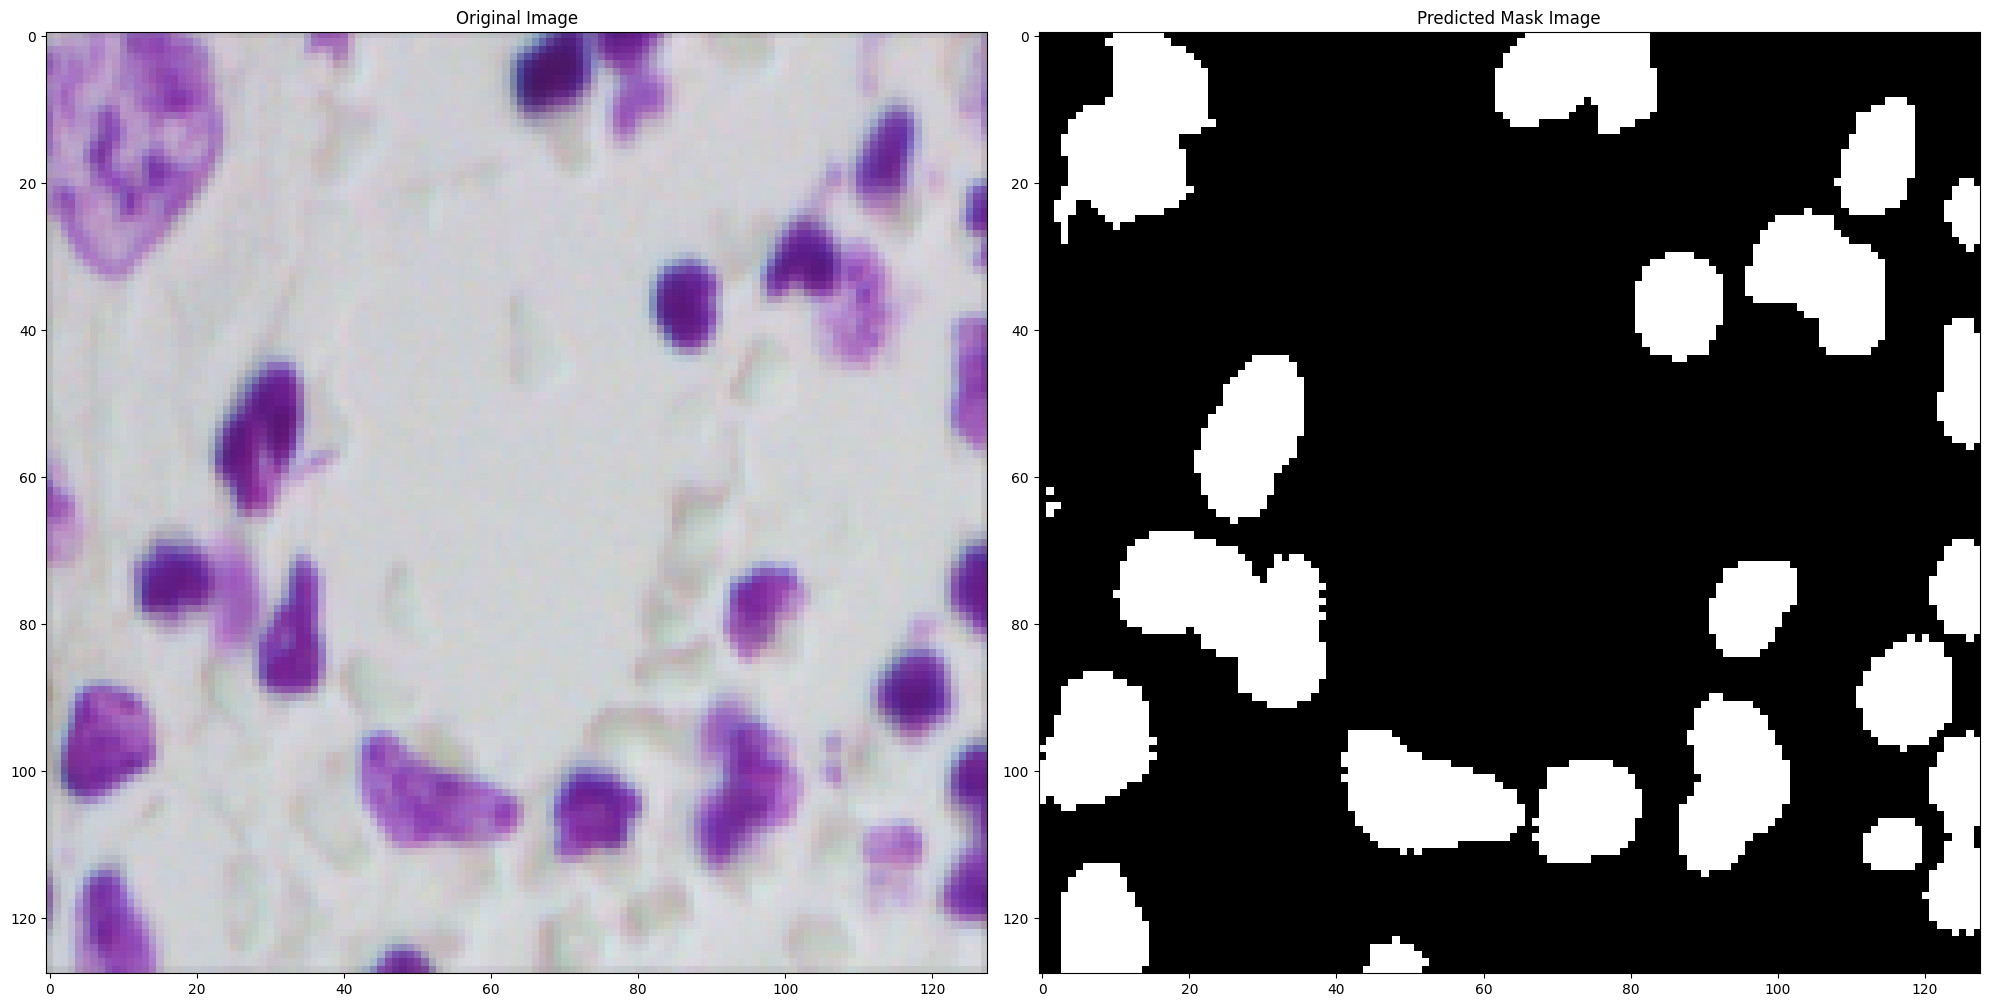

In [ ]:
# Ploting our predicted masks
ix = random.randint(602,668)
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(121)
imshow(X_train[ix])
plt.title("Original Image")

# The mask our U-Net model predicts
plt.subplot(122)
ix = ix-603
imshow(np.squeeze(preds_val_t[ix]>0.5))
plt.title("Predicted Mask Image")
plt.show()